# Microcanonical Hamiltonian Monte Carlo

Cose da **capire**:
- Autotuning di  L
- Implementare NUTS con NumPyro/PyMC
- Implementare MN integrator
- Paralelizzazione 🤠


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import sys
import torch

colors = [
    'red', 'green', 'blue', 'orange', 'purple', 'cyan',
    'magenta', 'yellow', 'black', 'white', 'gray', 'brown',
    'pink', 'olive', 'navy', 'teal', 'gold', 'lime', 'indigo',
    'turquoise', 'coral', 'maroon', 'aqua', 'plum', 'orchid'
    ]

In [ ]:
debug = True

def checkpoint(message = "", debug=True):
    if debug: print(message)
def warning(message = ""):
    print("WARNING: "+ message)

Let's first define the target distribution and the function used to compute the gradient of the loglikelihood.

In [ ]:
def standard_cauchy(x):
    """
    This function takes an array of d-dimensional points as input
        x = [x_1, x_2, ..., x_d]

    For each point x_i, it computes the value of the cauchy distribution as:
        p(x_i) = ( 1/(1+x_{i,1}**2) )*( 1/(1+x_{i,2}**2) )*...*( 1/(1+x_{i,d}**2) )

    The output is a tensor containing the values of the distribution for each point.
    """
    # serve che sia tensore di torch per implementazione del gradiente
    if not isinstance(x, torch.Tensor):
        x = torch.tensor(x, dtype=torch.float32)
    # dava problemi in una dimensione
    if x.dim() == 1:
        x = x.unsqueeze(1)
    return torch.prod(1 / (np.pi * (1 + x**2)), axis=1) #Why axis=1, am i interpreting the idea wrong?

def grad_log_likelihood(x, fn):
    """
    This function takes an array of d-dimensional points as input
        x = [x_1, x_2, ..., x_d]     with x_i  in R^d
    and a function fn that takes this array as argument.

    Then, computes the gradient (vector of the partial derivatives) of the loglikelihood
    of this function and evaluates it on each of the points in x
    """
    x = torch.tensor(x, requires_grad=True, dtype=torch.float32)
    L = -torch.log(fn(x))
    L.sum().backward() #with this command it calculates the gradients of L with respect to x and stores them in x.grad.

    # gradiente wrt x
    nablaL = x.grad.numpy()
    return nablaL

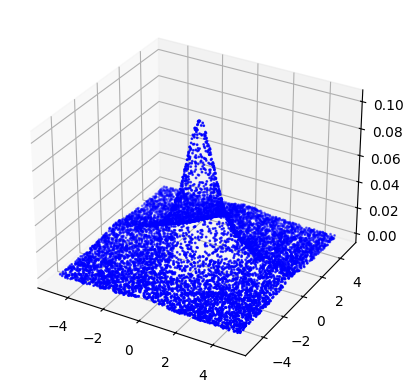

In [ ]:
# standard cauchy in 2D
x = np.random.uniform(low=-5, high=5, size=(10000, 2))

ax = plt.axes(projection='3d')
ax.scatter(x[:,0], x[:,1], standard_cauchy(x).numpy(), c='blue', s=1)
plt.show()

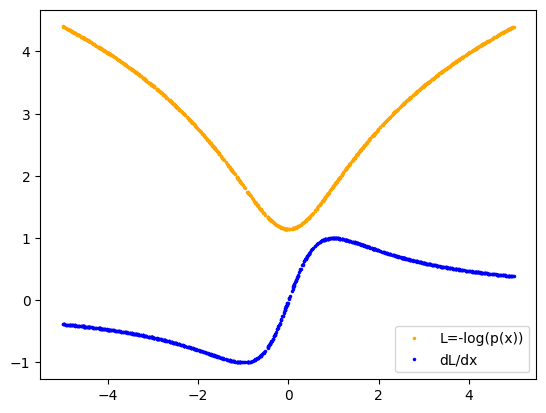

In [ ]:
# standard cauchy in 1D
x = np.random.uniform(low=-5, high=5, size=(1000, 1)) # 1000 one-dimensional points
L = -np.log(standard_cauchy(x).detach().numpy()) # the function whose gradient we want to compute: -loglikelyhood of the 1d cauchy distribution
nablaL = grad_log_likelihood(x, standard_cauchy)

plt.plot(x, L, 'o', color='orange', markersize=1.5, label='L=-log(p(x))')
plt.plot(x, nablaL, 'o', color='blue', markersize=1.5, label='dL/dx')
plt.legend()
plt.show()

-------------------------
Let's now define the maps used to update position and momentum via leapfrog integration scheme.

In [ ]:
def position_update_map(x: np.ndarray, u: np.ndarray, w: float, epsilon: float) -> tuple:
    new_x = x + epsilon * u
    new_u = u
    new_w = w
    return new_x, new_u, new_w

def momentum_update_map(x: np.ndarray, u: np.ndarray, w: float, epsilon: float, d: int, fn) -> tuple:

    # computing the gradient of the loglikelihood of the pdf fn
    nablaL = grad_log_likelihood(x, fn)

    delta = epsilon * np.linalg.norm(nablaL) / d
    e = - nablaL / np.linalg.norm(nablaL)

    # updating position
    new_x = x

    # updating momentum
    '''
    new_u = ( np.sinh(delta) + np.dot(e, u) * (np.cosh(delta) - 1) ) # CHECK: this should be a scalar
    new_u = new_u * e # CHECK: this should be a vector
    new_u = new_u + u # CHECK: this should still be a vector
    new_u = new_u / (np.cosh(delta) + np.dot(e, u) * (np.sinh(delta))) # CHECK: this should still be a vector
    '''
    prod = np.dot(e,u)
    s = np.sinh(delta)
    c = np.cosh(delta)
    new_u = (u + e * (s + prod * (c - 1)))/(c + prod * s)
    #new_u /= np.linalg.norm(new_u)

    # updating weight
    new_w = w * (c + prod * s)

    return new_x, new_u, new_w

def leapfrog(x: np.ndarray, u: np.ndarray, w: float, epsilon: float, d: int, fn) -> tuple:

    x, u, w = np.copy(x), np.copy(u), np.copy(w)

    # Update momentum by half step
    x, u, w = momentum_update_map(x, u, w, epsilon/2, d, fn)
    #checkpoint(f"x={x}, u={u}, w={w}")

    # Update position by one step
    x, u, w = position_update_map(x, u, w, epsilon)
    #checkpoint(f"x={x}, u={u}, w={w}")

    # Update momentum by half step
    x, u, w = momentum_update_map(x, u, w, epsilon/2, d, fn)
    #checkpoint(f"x={x}, u={u}, w={w}")
    return x, u, w

Here we define the sampling algorithm with bounces. For post-hoc analysis the energy is tracked after every step. It can be calculated via the hamiltonian, so $E=H(x, u)$ or via the weights as $w = \exp [(E-\mathcal{L}(x)/d]$, so $E=d\log w + \mathcal{L}(x)$

In [ ]:
def effective_sample_size(X, d, cauchy=False, debug=False):
    """
    This function computes the ESS used to evaluate the sampling algorithm used. In this
    case we are considering the MCHMC with q=0.

    NOTE:
    -The cauchy distribution case is special. We do not compute b_2 but we compute
    a coefficient b_L, function of the coordinate and momentum of a given
    simulation step. This should decrease during evolution. As it reaches a
    threshold value computed from theory, the simulation is considered converged
    and the ESS can be computed.

    -d should be very large for the validity of the approximations from which the
    formula are derived
    -----------------------------------------------------------------------------
    Args:
        X: vector of points sampled with MCHMC
        d: dimension of the problem
        cauchy: if True, the ESS is caluculated for the cauchy distribution
    """
    convergence_reached = False

    if cauchy:
        def cauchy_1D(x_i):
            """
            cauchy distribution in 1D
            """
            return 1/(np.pi*(1+x_i**2))

        # Retrieving the number of samples simulated
        #checkpoint(f"points shape: {X.shape}, dimension: {d}", debug) #consistency check
        n_samples = X.shape[0]

        # Computing and storing the expectation values of -loglikelyhood
        # for each dimension separately
        partial_results = []
        for dim in range(d):
            x_dim = X[:,dim] # sampled points over a single dimension
            cauchy_evaluations = np.vectorize(cauchy_1D)(x_dim)
            minus_L_evaluations = -np.log(cauchy_evaluations)
            partial_results.append(minus_L_evaluations)
        partial_results = np.array(partial_results) #here you have d rows and n_samples columns
        if partial_results.shape[0] != d or partial_results.shape[1] != n_samples:
            sys.exit("Something is wrong with partial results")

        # Computing the expectation value of -loglikelyhood over the samples, for the different dimensions
        E_sampler = np.mean(partial_results, axis=1) # mean over each row (each dimension)

        # Results from paper:
        E_truth = np.log(4*np.pi)
        threshold = 0.0165

        # Computing the value of b_L and check for convergence
        b_L_squared = (1/d)*np.sum((E_sampler-E_truth)**2)
        b_L = np.sqrt(b_L_squared)

        # Computing the Effective Sample Size
        n_eff = ( (np.pi**2) / 3 ) / b_L_squared
        ESS = n_eff / n_samples
        checkpoint(f"\tb_L: {np.sqrt(b_L_squared)}, ESS: {ESS}", debug)

        if  b_L < threshold:
            convergence_reached = True

        return b_L_squared, ESS, convergence_reached

    else:
        sys.exit("Distribution not implemented yet")

In [ ]:
def energy(x, w, fn):
    """
    This function computes t
    he energy of the system
    """
    d = len(x)
    NLP = -torch.log(fn(x)).numpy().sum() #Negative log posterior
    return d * np.log(w) + NLP

def MCHMC_bounces(d, N, L, epsilon, post_fn, debug=False):
    """
    This function implements the MCHMC algorithm for the q=0 case with random momentum
    bounces every K steps.
    Args:
        N: number of steps
        L: distance between momentum bounces
        epsilon: step size
    Output:
        X: positions during evolution
        U: momentum directions during evolution
        W: momentum amplitudes during evolution
        E: energies during evolution
        ESS: effective sample sizes during evolution
        converged: boolean indicating if the evolution has converged

    """

    K = int(L // epsilon) #  steps between bounces

    # Defining arrays where to store results of evolution
    X = np.zeros((N+1, d))
    U = np.zeros((N+1, d))
    W = np.zeros(N+1)
    E = np.zeros(N+1)
    ESS = np.zeros(N+1)
    B_squared = np.zeros(N+1)

    #######################################################
    # STEP 0: Intial conditions
    x = np.random.uniform(low=-2, high=2, size=(d,)) # Sample initial position x_o in R^d from prior
    u = np.random.randn(d) # Sample initial direction of momentum u_0 from isotropic distribution in R^d
    u /= np.linalg.norm(u)
    w = 1 # Set the intial weight
    checkpoint(f"Step {0} (initialization):", debug)
    if d<10:
        checkpoint(f"\tx = {x}\n\tu = {u}\n\tw = {w}", debug)
    X[0] = x
    U[0] = u
    W[0] = w
    E[0] = energy(x, w, post_fn)
    squared_b, eff_ss, converged = effective_sample_size(X, d, cauchy=True, debug=debug)
    B_squared[0] = squared_b
    ESS[0] = eff_ss

    #if d < 100:
    #    warning(f"For the validity of ESS results d should be very large but I am using d={d}")
    #warning("Check that X has not been flatten")

    #######################################################
    # EVOLUTION: Algorithm implementation
    for n in range(1,N+1):

        checkpoint(f"Step {n+1}:", debug)

        # if K steps has been done, apply a bounce
        if n % K == 0:
            u = np.random.randn(d)
            u /= np.linalg.norm(u)

        # Updating coordinate and momentum
        x, u, w = leapfrog(x, u, w, epsilon, d, post_fn)
        if d<10:
            checkpoint(f"\tx = {x}\n\tu = {u}\n\tw = {w}", debug)
        if not np.isclose(np.linalg.norm(u), 1.0, atol=1e-4):
            sys.exit(f"Vector u should be normalized, while its norm is {np.linalg.norm(u)}.")

        # Storing results
        X[n] = x
        U[n] = u
        W[n] = w
        E[n] = energy(x, w, post_fn)
        squared_b, eff_ss, converged = effective_sample_size(X, d, cauchy=True, debug=debug) #compute it after determine the new points in phase space
        B_squared[n] = squared_b
        ESS[n] = eff_ss

    return X, U, W, E, ESS, converged



--------------------
Here we write the algorithm to implement the MCHMC steps:

In [ ]:
# ALGORITHM PARAMETERS
d = 5  # dimension of the problem
N = 20000 # number of steps
epsilon = 0.1 # step size
L = 1 # distance between momentum bounces
K = int(L//epsilon) #  steps between bounces

checkpoint(f"Number of steps N = {N}")
checkpoint(f"Steps between bounces K = {K}")
checkpoint(f"Number of bounces: {int(N//K)}")

Number of steps N = 20000
Steps between bounces K = 9
Number of bounces: 2222


In [ ]:
X, *_ = MCHMC_bounces(d, N, L, epsilon, standard_cauchy, debug=debug)
print("end")

Step 0 (initialization):
	x = [-1.06394615 -0.2366096   0.75219442 -0.80512822  1.39612841]
	u = [ 0.98359762 -0.15100074  0.00472503 -0.08005074 -0.05748085]
	w = 1
	b_L: 1.3862659511684106, ESS: 8.559209725242689e-05
Step 2:
	x = [-0.60219357 -0.29461053  0.73372074 -0.82003174  1.35010447]
	u = [ 0.98258508 -0.09354021 -0.08133377  0.01445439 -0.13766875]
	w = 1.0947003535885658
	b_L: 1.3862421988439149, ESS: 8.559503040319527e-05
Step 3:
	x = [-0.86540661 -0.2046395   0.44511784 -1.05013737  1.27497113]
	u = [-0.52279551  0.21313449 -0.65932551 -0.45074312 -0.20827638]
	w = 1.0694798661903682
	b_L: 1.386217307095121, ESS: 8.55981044221289e-05
Step 4:
	x = [-1.08970055 -0.09570697  0.11851044 -1.2403214   1.15561988]
	u = [-0.43984574  0.24539995 -0.71996686 -0.36670632 -0.30575936]
	w = 1.046955864516262
	b_L: 1.3861914536956546, ESS: 8.560129737591356e-05
Step 5:
	x = [-0.77458233 -0.18219735  0.06158548 -0.91045914  1.13484718]
	u = [ 0.67491599 -0.15720351 -0.11955419  0.7056817

KeyboardInterrupt: 

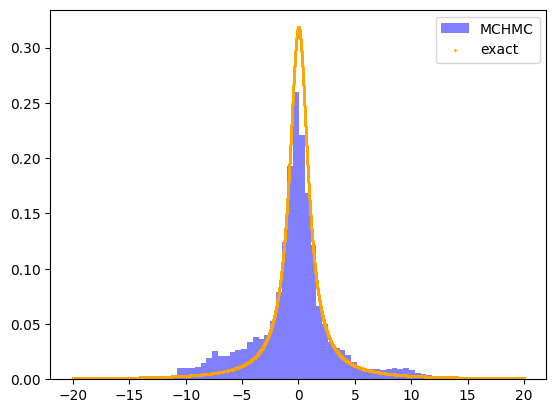

In [ ]:
X = X.flatten()
x = np.linspace(-20, 20, 10000)
plt.hist(X, density=True, alpha=0.5, bins=50, color='blue', label='MCHMC')
plt.scatter(x, standard_cauchy(x).numpy(), color='orange', s=1, label='exact')
plt.legend()
plt.show()

# Langevin HMC

In [ ]:
def stochastic_update_map():
  """
  Write the stochastic update phi^O here. A Langevin integration step with Velocity-Leapfrog
  consists of a stochastic update, a momentum half-update, a position update
  and a final momentum half-update
  """
  return 0

def MCHMC_langevin():
  """
  Write the code for Langevin MCHMC here.
  """
  return 0

# Hyperparameter tuning

## 1. Step size $\epsilon$
- Start with $\epsilon_0=0.5$ and run for $\mathcal{O}(100 \text{ steps})$
- Calculate $\text{Var}[E]$
- Update the step size $\epsilon_{i+1} = \epsilon_i(0.0005 d/\text{Var}[E])^{1/4}$
- Repeat until convergence

In [ ]:
def tune_eps(d, L, post_fn, N=400):
  epsilon = 0.5
  eps_arr = []
  #Change to an "until convergence" criterion, could track ((eps_i+1 - eps_i)/eps_i)^2 and get it lower
  #than a threshold
  for i in range(10):
    checkpoint(f"iter {i}")
    X, _, _, E, _, _= MCHMC_bounces(d, N, L, epsilon, post_fn)
    VarE = E.var()
    epsilon *= (0.0005 * d / VarE)**(1/4)
    eps_arr.append(epsilon)
  return np.array(eps_arr), X, E

In [ ]:
eps, X, E = tune_eps(d, L, standard_cauchy)
epsilon = eps[-1]
print(f"epsilon={epsilon}")

iter 0
iter 1
iter 2
iter 3
iter 4
iter 5
iter 6
iter 7
iter 8
iter 9
epsilon=0.46825328921401477


## 2. Momentum decoherence scale $L$
- After having tuned $\epsilon$ and estimated $\sigma_{eff}^2=\frac{1}{d}\sum_{i=1}^d \text{Var}[x_i^2]$
- Start with $L_0=\sigma_{eff}\sqrt{d}$
- Run for $n$ steps to estimate the effective sample size for each dimension (??)
- Compute the decoherence scale as
$$L=0.4\dfrac{\epsilon}{d^{-1}\sum_{i=1}^d n_{eff}^{(i)}/n}$$

In [ ]:
def s_eff(X):
  return np.sqrt((X**2).var(axis=0).mean())

def tune_L(d, sigma_ef, epsilon, N_prerun):
  L = sigma_eff * np.sqrt(d) #initial value

  for mm in range(N_prerun):
    # da capire come usare i risultati per ESS che vengono calcolati in MCHMC_bounces

  return L

In [ ]:
sigma_eff = s_eff(X)
print(f"sigma_eff={sigma_eff}")
# tune_L()